In [1]:
#!pip install git+https://github.com/openai/CLIP.git

In [6]:
import torch
from tqdm import tqdm
import os
import clip
from PIL import Image
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
#from google.colab import drive

#loading CLIP MODEL and preprocessing function
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device = device)

/home/saurav/base_env/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [7]:
#defining image paths and files
DATA_PATH = '/home/saurav/Documents'
image_folder = DATA_PATH+'/required_dataset/images'
embeddings = {}
batch_size = 8
checkpoint_file = "clip_embeddings_checkpoint.pkl"
final_embeddings = "clip_embeddings_batch.pkl"

In [8]:
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        embeddings = pickle.load(f)
    processed_ids = set(embeddings.keys())  

In [9]:
len(embeddings)

44447

In [10]:
#Query image embedding
Q_IMAGE_PATH = DATA_PATH + "/ViberDownloads/bipin.jpg"
q_image = preprocess(Image.open(Q_IMAGE_PATH)).unsqueeze(0).to(device)
with torch.no_grad():
    q_image_embedding = model.encode_image(q_image).cpu().numpy()

In [11]:
#Query text embedding
q_text = "men's black tshirt with white strip"
tokenized_q_text = clip.tokenize(q_text).to(device)
with torch.no_grad():
    q_text_embedding = model.encode_text(tokenized_q_text).cpu().numpy()

In [12]:
#embeddings['15970']['text_embedding']

In [13]:
#extraction of all unique id from the dictionary
dataset_ids = list(embeddings.keys())

#extraction of text embeddings 
dataset_text_embeddings = torch.stack(
    [torch.tensor(embeddings[unique_id]['text_embedding']) for unique_id in dataset_ids]
)

In [14]:
#as the cosine similarity only measures the angle between two vectors so to ensure that the similarity only reflects 
#the direction of the vectors, we normalize all the embeddings to have a unit norm i.e length=1

#note: calculating cosine similarity includes COSINE_SIMILARITY = (A.B)/(|A| |B|) which means the denominator
#      is the magnitude and if the vectors aren't normalized in the unit scale, the vectors with larger 
#      magnitude will dominate the similarity score, even if their directions are poorly aligned.
dataset_text_embeddings = dataset_text_embeddings / dataset_text_embeddings.norm(dim=-1, keepdim=True)

#converting q_text embedding to tensor format
q_text_embedding = torch.tensor(q_text_embedding)
q_text_embedding = q_text_embedding / q_text_embedding.norm(dim=-1, keepdim=True)

In [15]:
dataset_text_embeddings.shape

torch.Size([44447, 512])

In [16]:
#computing cosine similarity 
cosine_similarity = torch.matmul(q_text_embedding, dataset_text_embeddings.T).squeeze()

In [17]:
#top k matches retrieval
top_k = 5
top_indices = torch.topk(cosine_similarity, k=top_k).indices

In [18]:
top_indices

tensor([ 4538, 29150, 33073, 44437, 12860])

Match ID: 9867, Similarity Score: 0.8038026690483093


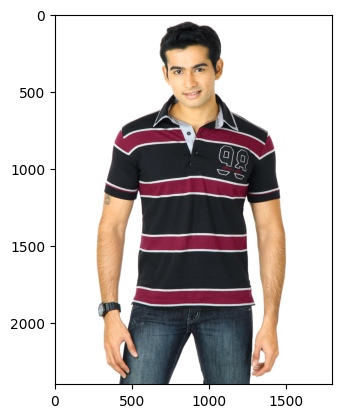

Match ID: 14943, Similarity Score: 0.8038026690483093


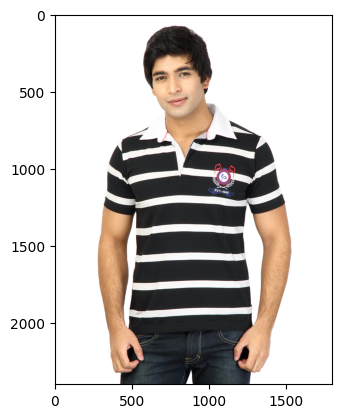

Match ID: 14942, Similarity Score: 0.8038026690483093


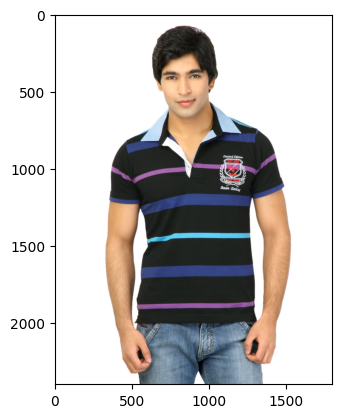

Match ID: 30614, Similarity Score: 0.7916193604469299


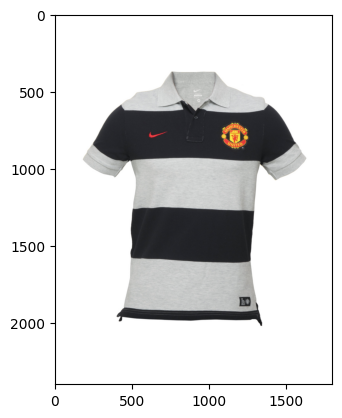

Match ID: 9558, Similarity Score: 0.7880442142486572


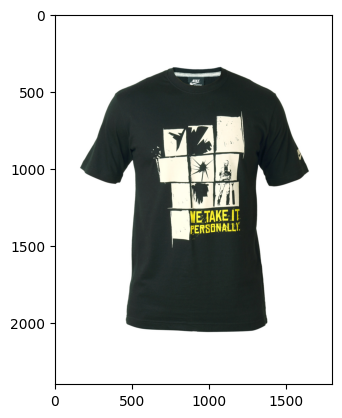

In [19]:
for idx in top_indices:
    unique_id = dataset_ids[idx]  #retrieve unique id for this embedding
    unique_image = unique_id + '.jpg'
    similarity_score = cosine_similarity[idx].item()
    print(f"Match ID: {unique_id}, Similarity Score: {similarity_score}")
    image_dir = image_folder +'/'+ unique_image
    image_data = plt.imread(image_dir)
    plt.imshow(image_data)
    plt.show()

In [20]:
cosine_similarity.shape

torch.Size([44447])